In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Очистка
Очистим `Age`, закодируем `Sex`, уберем `PassengerId`, `Name`, `Cabin`, `Embarked` и `Ticket`

In [39]:
df.drop(['PassengerId', 'Name', 'Cabin', 'Embarked', 'Ticket'], axis=1, inplace=True)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

grouped_age = df.groupby(['Pclass', 'Sex'])['Age'].median()

def fill_age(x):
    if np.isnan(x['Age']):
        return grouped_age[x['Pclass'], x['Sex']]
    return x['Age']

df['Age'] = df.apply(fill_age, axis=1)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


## Визуализация + Нормализация

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

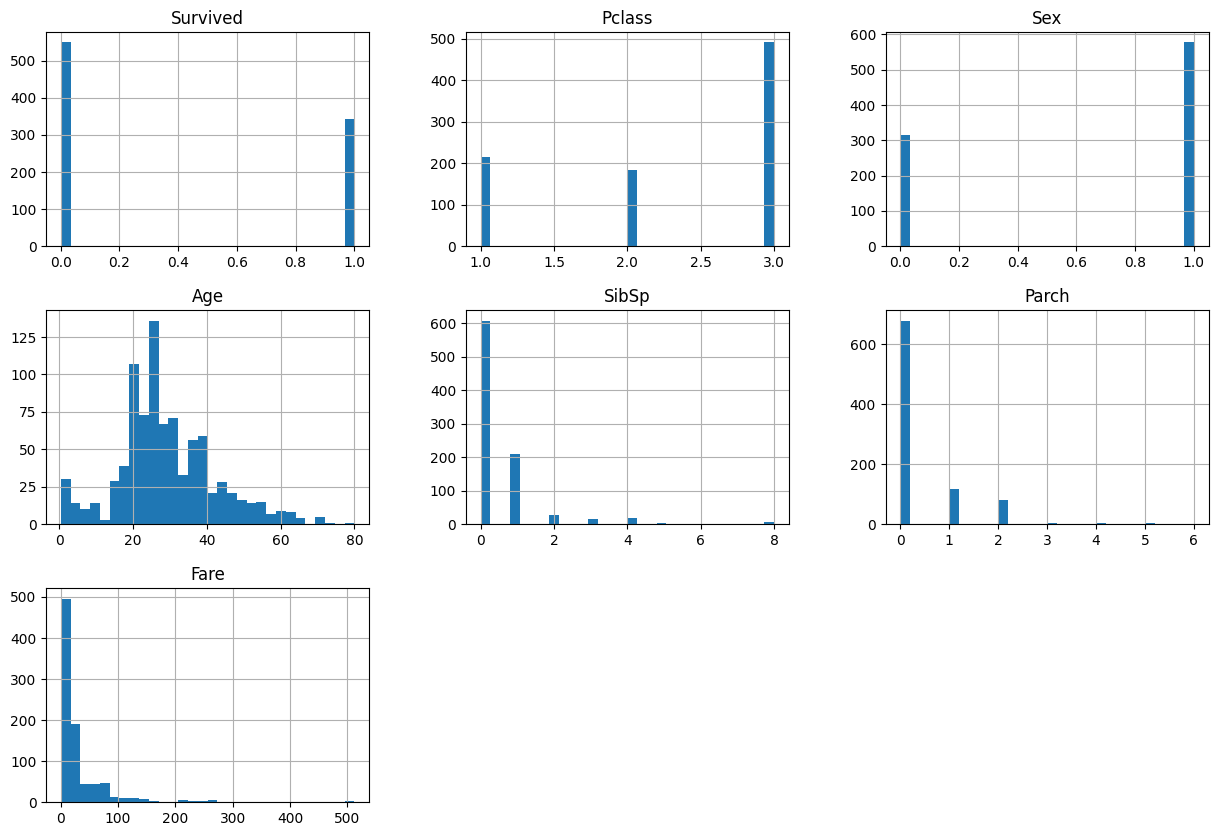

In [41]:
df.hist(bins=30, figsize=(15, 10))

Нормализируем `Fare` и `Age` с помощью StandardScalar

In [42]:
df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['Fare'] = (df['Fare'] - df['Fare'].mean()) / df['Fare'].std()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000,8.910000e+02
mean,0.383838,2.308642,0.647587,2.113286e-16,0.523008,0.381594,-1.196200e-17
std,0.486592,0.836071,0.477990,1.000000e+00,1.102743,0.806057,1.000000e+00
min,0.000000,1.000000,0.000000,-2.156608e+00,0.000000,0.000000,-6.480577e-01
25%,0.000000,2.000000,0.000000,-5.721724e-01,0.000000,0.000000,-4.888737e-01
50%,0.000000,3.000000,1.000000,-2.339390e-01,0.000000,0.000000,-3.571902e-01
75%,1.000000,3.000000,1.000000,5.176906e-01,1.000000,0.000000,-2.423274e-02
max,1.000000,3.000000,1.000000,3.824861e+00,8.000000,6.000000,9.661740e+00


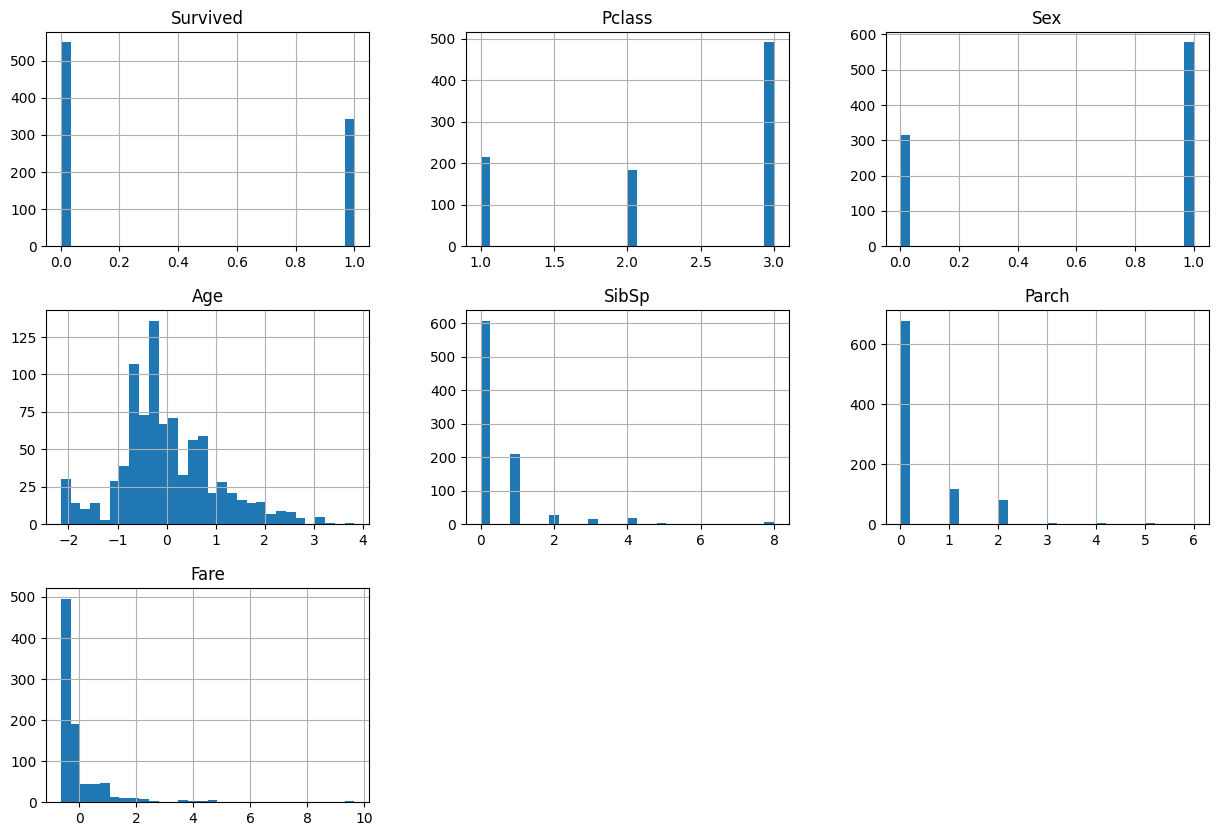

In [43]:
df.hist(bins=30, figsize=(15, 10))
df.describe()

## Logistic Regression

In [44]:
def logit(x, w):
    return np.dot(x, w)


def sigmoid(h):
    return 1. / (1 + np.exp(-h))


def generate_batches(X, y, batch_size):
    assert len(X) == len(y)
    np.random.seed(52) #52525252
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    for batch_start in range(0, len(X) - batch_size + 1, batch_size):
        prog = perm[batch_start:batch_start + batch_size]
        yield X[prog], y[prog]

In [45]:
class LogisticRegression(object):
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape        
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)        
        losses = []

        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):
                predictions = self._predict_proba_internal(X_batch)
                loss = self.__loss(y_batch, predictions)
                losses.append(loss)
                self.w -= lr*self.get_grad(X_batch, y_batch, predictions)

        return losses
    
    def get_grad(self, X_batch, y_batch, predictions): 
        grad_basic = X_batch.T @ (predictions - y_batch)
        return grad_basic
        
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X): 
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w.copy()
        
    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

## Train-Test-Split

In [49]:
samples_amount = 0.3
random_state = 336771

x = df.drop('Survived', axis=1)
y = df['Survived']

test_x = x.sample(frac=samples_amount, random_state=random_state)
test_y = y[test_x.index]
train_x = x.drop(test_x.index, axis=0)
train_y = y[train_x.index]


test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()

## Training + Testing

In [53]:
def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    return correct_predictions / len(true_labels)

In [54]:
from time import time
import warnings
warnings.filterwarnings('ignore')


epochs_x = np.array(list(range(1, 50)))
lr_x = np.linspace(0.0001, 0.999, 25)
batch_size_x = np.array(list(range(10, 21)))

print(f"Testing {len(epochs_x) * len(lr_x) * len(batch_size_x)} cases:")

start = time()

best_params_scr = 0
best_params = {}
i = 1
for epochs in epochs_x:
    for lr in lr_x:
        for batch_size in batch_size_x:
            case_start = time()

            log_reg = LogisticRegression()
            log_reg.fit(train_x, train_y, epochs, lr, batch_size)
            pred_y = log_reg.predict(test_x)
            scr = calculate_accuracy(test_y, pred_y)

            if scr > best_params_scr:
                best_params_scr = scr
                best_params = {
                    "epochs": epochs,
                    "lr": lr,
                    "batch_size": batch_size
                }

            print(f"Case {i} finished in {time() - case_start}")
            i += 1

print(f"Finished in {time() - start} second(s)")

Testing 13475 cases:
Case 1 finished in 0.0
Case 2 finished in 0.0
Case 3 finished in 0.0
Case 4 finished in 0.0
Case 5 finished in 0.0
Case 6 finished in 0.0
Case 7 finished in 0.0
Case 8 finished in 0.0
Case 9 finished in 0.0
Case 10 finished in 0.0
Case 11 finished in 0.0
Case 12 finished in 0.0
Case 13 finished in 0.01572132110595703
Case 14 finished in 0.0
Case 15 finished in 0.0
Case 16 finished in 0.0
Case 17 finished in 0.0
Case 18 finished in 0.0
Case 19 finished in 0.0
Case 20 finished in 0.0
Case 21 finished in 0.0
Case 22 finished in 0.0
Case 23 finished in 0.0
Case 24 finished in 0.0
Case 25 finished in 0.0
Case 26 finished in 0.0
Case 27 finished in 0.0
Case 28 finished in 0.0
Case 29 finished in 0.0
Case 30 finished in 0.0
Case 31 finished in 0.0
Case 32 finished in 0.0
Case 33 finished in 0.0
Case 34 finished in 0.0
Case 35 finished in 0.01575636863708496
Case 36 finished in 0.0006885528564453125
Case 37 finished in 0.0
Case 38 finished in 0.0
Case 39 finished in 0.0
Ca

In [55]:
print(best_params)

{'epochs': np.int64(7), 'lr': np.float64(0.8325166666666667), 'batch_size': np.int64(17)}
